In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow.keras as keras

from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.models import load_model #save and load models
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import average_precision_score
import tensorflow.keras.backend as k

2025-01-20 11:58:20.622096: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-20 11:58:20.622568: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-20 11:58:20.624699: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-20 11:58:20.630439: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737385100.640064   83135 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737385100.64

In [3]:
df = pd.read_csv('data/adult.data',  names=[
        "Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Martial Status",
        "Occupation", "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss",
        "Hours per week", "Country", "Target"],
        sep=r'\s*,\s*',
        engine='python',
        na_values="?")

In [4]:
df1 = pd.read_csv("data/adult.test",
    names=[
        "Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Martial Status",
        "Occupation", "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss",
        "Hours per week", "Country", "Target"],
        sep=r'\s*,\s*',
        engine='python',\
        na_values="?")

In [5]:
data = pd.concat([df, df1], ignore_index= True)


In [6]:
names_cloud = data.columns.tolist()
print(names_cloud)
X = np.array(data[names_cloud])
print(X.shape)

['Age', 'Workclass', 'fnlwgt', 'Education', 'Education-Num', 'Martial Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Capital Gain', 'Capital Loss', 'Hours per week', 'Country', 'Target']
(48842, 15)


In [7]:
y = (data['Target'].map({"<=50K":0,">50K":1})).values
print(pd.value_counts(pd.Series(y)))
data.drop('Target',axis=1, inplace =True,)

0    37155
1    11687
Name: count, dtype: int64


/tmp/ipykernel_83135/3481380141.py:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  print(pd.value_counts(pd.Series(y)))


In [8]:
categorical_features = data.select_dtypes(include=['object']).columns
print(categorical_features)
ohc_category = ['Workclass', 'Education', 'Martial Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country']
df_ohc = pd.get_dummies(data, columns = ohc_category)


Index(['Workclass', 'Education', 'Martial Status', 'Occupation',
       'Relationship', 'Race', 'Sex', 'Country'],
      dtype='object')


In [9]:
names_x = df_ohc.columns.tolist()
print("Target Variable: Target")
print("Predictors: "+str(names_x))
x = np.array(df_ohc[names_x])
print("Number of data samples : {0:d}".format(x.shape[0]))
print("Number of Predictor Features : {0:d}".format(x.shape[1]))

Target Variable: Target
Predictors: ['Age', 'fnlwgt', 'Education-Num', 'Capital Gain', 'Capital Loss', 'Hours per week', 'Workclass_Federal-gov', 'Workclass_Local-gov', 'Workclass_Never-worked', 'Workclass_Private', 'Workclass_Self-emp-inc', 'Workclass_Self-emp-not-inc', 'Workclass_State-gov', 'Workclass_Without-pay', 'Education_10th', 'Education_11th', 'Education_12th', 'Education_1st-4th', 'Education_5th-6th', 'Education_7th-8th', 'Education_9th', 'Education_Assoc-acdm', 'Education_Assoc-voc', 'Education_Bachelors', 'Education_Doctorate', 'Education_HS-grad', 'Education_Masters', 'Education_Preschool', 'Education_Prof-school', 'Education_Some-college', 'Martial Status_Divorced', 'Martial Status_Married-AF-spouse', 'Martial Status_Married-civ-spouse', 'Martial Status_Married-spouse-absent', 'Martial Status_Never-married', 'Martial Status_Separated', 'Martial Status_Widowed', 'Occupation_Adm-clerical', 'Occupation_Armed-Forces', 'Occupation_Craft-repair', 'Occupation_Exec-managerial', 

# Modelo Alvo Original

In [10]:
x = x.astype('float32')
scaler = MinMaxScaler()

x = scaler.fit_transform(x)


data_size = 10000
ns = 5 #number of shadow models for one data_size

nout = 1
seed = 7
np.random.seed(seed)
sh = np.arange(x.shape[0])
np.random.shuffle(sh)
target_rep = np.zeros((1,x.shape[0]))
target_rep[0,:] = sh
print(sh)

[23509 38928 23796 ...   919 38467 10742]


In [11]:
k.clear_session()

xtr_target = x[sh[:data_size]]
ytr_target = y[sh[:data_size]]
xts_target = x[sh[data_size:data_size*2]]
yts_target = y[sh[data_size:2*data_size]]

shadow_rep = np.zeros((5,x.shape[0]-2*data_size))
sh1 = sh[2*data_size:]
xtr_att = np.zeros((2*data_size*ns,1))
ytr_att = np.zeros((2*data_size*ns,1))
xtr_att_truelabels = np.zeros((2*data_size*ns,))

model_target = Sequential()
model_target.add(Dense(5, input_shape =(x.shape[1],), activation='sigmoid', name = 'hidden'))
model_target.add(Dense(1, activation='sigmoid', name = 'output'))
opt = keras.optimizers.Adam(learning_rate=0.001, decay = 1e-7)
model_target.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
print(model_target.summary())
hist_target = model_target.fit(xtr_target, ytr_target,
                  batch_size = 32,
                  epochs = 100,
                  validation_data=(xts_target, yts_target), shuffle=True, verbose=0)
print('\n\nFor target model with training datasize = %d'%data_size)
print('Training accuracy = %f'%hist_target.history['accuracy'][-1])
print('Validation accuracy = %f'%hist_target.history['val_accuracy'][-1])
model_target_name = 'UCI_Adult_target_'+str(data_size)+'.h5'

model_target.save(model_target_name)

ytemp_tr_target = model_target.predict(xtr_target)
ytemp_ts_target = model_target.predict(xts_target)

xts_att = np.vstack((ytemp_tr_target,ytemp_ts_target))
yts_att = np.zeros((2*data_size,1))
yts_att[data_size:2*data_size] = 1
xts_att_truelabels = np.vstack((ytr_target,yts_target))
xts_att_dict = {'xts_att':xts_att,'yts_att':yts_att,'xts_att_truelabels':xts_att_truelabels}
fname = './att_test_data_'+str(data_size)
np.save(fname,xts_att_dict)
datafile = './data_adult_target_'+str(data_size)
np.save(datafile,target_rep)

/media/emanuel/sdd_sata/projetos/projeto_mestrado_ofc/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
W0000 00:00:1737385134.724372   83135 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/media/emanuel/sdd_sata/projetos/projeto_mestrado_ofc/.venv/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden (Dense)                  │ (None, 5)              │           530 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 536 (2.09 KB)

 Trainable params: 536 (2.09 KB)

 Non-trainable params: 0 (0.00 B)

None




For target model with training datasize = 10000
Training accuracy = 0.850000
Validation accuracy = 0.849800
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step


## Modelo Sombra

In [12]:
for i in np.arange(ns):

    np.random.shuffle(sh1)
    shadow_rep[i,:] = sh1
    xtr_shadow = x[sh1[:data_size]]
    ytr_shadow = y[sh1[:data_size]]
    xts_shadow = x[sh1[data_size:2*data_size]]
    yts_shadow = y[sh1[data_size:2*data_size]]

    model_shadow = Sequential()
    model_shadow.add(Dense(5, input_shape =(x.shape[1],), activation='sigmoid', name = 'hidden'))
    model_shadow.add(Dense(1, activation='sigmoid', name = 'output'))
    opt = keras.optimizers.Adam(learning_rate=0.001, decay=1e-7)
    model_shadow.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    if i == 0:
        print("Shadow Model Summary")
        print(model_shadow.summary())
    hist_shadow = model_shadow.fit(xtr_shadow, ytr_shadow,
                  batch_size = 32,
                  epochs = 100,
                  validation_data=(xts_shadow, yts_shadow), shuffle=True, verbose=0)
    print("Shadow model no: %d"%i)
    print('\n\nFor shadow model with training datasize = %d'%data_size)
    print('Training accuracy = %f'%hist_shadow.history['accuracy'][-1])
    print('Validation accuracy = %f'%hist_shadow.history['val_accuracy'][-1])

    ytemp11 = model_shadow.predict(xtr_shadow)
    ytemp22 = model_shadow.predict(xts_shadow)

    model_shadow_name = 'UCI_Adult_shadow_'+str(data_size)+'_'+str(i)+'.h5'
    print(model_shadow_name)
    model_shadow.save(model_shadow_name)

    xtr_att[i*2*data_size:(i+1)*2*data_size] = np.vstack((ytemp11,ytemp22))
    ytr_att[((i*2)+1)*data_size:(i+1)*2*data_size] = 1
    xtr_att_truelabels[i*2*data_size:(i+1)*2*data_size] = np.hstack((ytr_shadow,yts_shadow))

datafile = './data_adult_shadow_'+str(data_size)
np.save(datafile,shadow_rep)
xtr_att_dict = {'xtr_att':xtr_att,'ytr_att':ytr_att,'xtr_att_truelabels':xtr_att_truelabels}
fname = './att_train_data_'+str(data_size)
np.save(fname,xtr_att_dict)

Shadow Model Summary


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden (Dense)                  │ (None, 5)              │           530 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 536 (2.09 KB)

 Trainable params: 536 (2.09 KB)

 Non-trainable params: 0 (0.00 B)

None
Shadow model no: 0


For shadow model with training datasize = 10000
Training accuracy = 0.855900
Validation accuracy = 0.851200
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


UCI_Adult_shadow_10000_0.h5
Shadow model no: 1


For shadow model with training datasize = 10000
Training accuracy = 0.859100
Validation accuracy = 0.850500
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step


UCI_Adult_shadow_10000_1.h5
Shadow model no: 2


For shadow model with training datasize = 10000
Training accuracy = 0.858800
Validation accuracy = 0.848700
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step


UCI_Adult_shadow_10000_2.h5
Shadow model no: 3


For shadow model with training datasize = 10000
Training accuracy = 0.863600
Validation accuracy = 0.845600
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step


UCI_Adult_shadow_10000_3.h5
Shadow model no: 4


For shadow model with training datasize = 10000
Training accuracy = 0.857800
Validation accuracy = 0.850100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step


UCI_Adult_shadow_10000_4.h5


# Modelo de Ataque

In [13]:
model_attack = Sequential()
model_attack.add(Dense(5, input_shape = (xtr_att.shape[1],), activation='sigmoid', name = 'hidden'))
model_attack.add(Dense(1, activation='sigmoid', name = 'output'))
opt = keras.optimizers.Adam(learning_rate=0.001, decay=1e-7)
model_attack.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
print("Attack Model Summary")
print(model_attack.summary())
hist_attack = model_attack.fit(xtr_att, ytr_att,
                  batch_size = 32,
                  epochs = 100,
                  validation_data=(xts_att, yts_att), shuffle=True, verbose=0)
print('\n\nFor attack model with training datasize = %d'%xtr_att.shape[0])
print('Training accuracy = %f'%hist_attack.history['accuracy'][-1])
print('Validation accuracy = %f'%hist_attack.history['val_accuracy'][-1])
y_score = model_attack.predict(xts_att)
average_precision = average_precision_score(yts_att, y_score)
print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Attack Model Summary


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden (Dense)                  │ (None, 5)              │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16 (64.00 B)

 Trainable params: 16 (64.00 B)

 Non-trainable params: 0 (0.00 B)

None


For attack model with training datasize = 100000
Training accuracy = 0.499750
Validation accuracy = 0.500000
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step
Average precision-recall score: 0.50


## COmbinando amostras entre alvo e sombras no conjunto de teste do ataque

In [14]:
# # First, collect predictions from both target and shadow models for test set
# # Assuming we want to use 20% of each shadow model's predictions in the test set

# # Original target model predictions
# ytemp_tr_target = model_target.predict(xtr_target)  # predictions on target train data
# ytemp_ts_target = model_target.predict(xts_target)  # predictions on target test data

# Calculate how many samples we want from each shadow model
shadow_samples_per_model = int(0.2 * data_size)  # 20% of data_size
total_shadow_samples = shadow_samples_per_model * ns  # ns is number of shadow models

# Initialize arrays for combined test set
xts_att_combined = np.zeros((2*data_size + total_shadow_samples, 1))
yts_att_combined = np.zeros((2*data_size + total_shadow_samples, 1))
xts_att_truelabels_combined = np.zeros((2*data_size + total_shadow_samples,))

# First, add all target model predictions
xts_att_combined[:2*data_size] = np.vstack((ytemp_tr_target, ytemp_ts_target))
yts_att_combined[:data_size] = 0  # members (target train)
yts_att_combined[data_size:2*data_size] = 1  # non-members (target test)
xts_att_truelabels_combined[:2*data_size] = np.hstack((ytr_target, yts_target))

# Then add portions of shadow model predictions
current_index = 2*data_size

for i in np.arange(ns):
    # Load or get predictions from each shadow model
    model_shadow = load_model(f'UCI_Adult_shadow_{data_size}_{i}.h5')

    # Get predictions from shadow model
    shadow_tr_preds = model_shadow.predict(xtr_shadow)  # predictions on shadow train data
    shadow_ts_preds = model_shadow.predict(xts_shadow)  # predictions on shadow test data

    # Randomly select samples from both train and test predictions
    combined_preds = np.vstack((shadow_tr_preds, shadow_ts_preds))
    combined_labels = np.hstack((np.zeros(data_size), np.ones(data_size)))  # 0 for members, 1 for non-members
    combined_true_labels = np.hstack((ytr_shadow, yts_shadow))

    # Randomly select indices
    random_indices = np.random.choice(2*data_size, shadow_samples_per_model, replace=False)

    # Add selected predictions and their labels to test set
    end_index = current_index + shadow_samples_per_model
    xts_att_combined[current_index:end_index] = combined_preds[random_indices].reshape(-1, 1)
    yts_att_combined[current_index:end_index] = combined_labels[random_indices].reshape(-1, 1)
    xts_att_truelabels_combined[current_index:end_index] = combined_true_labels[random_indices]

    current_index = end_index

# Save the combined test data
xts_att_dict = {
    'xts_att': xts_att_combined,
    'yts_att': yts_att_combined,
    'xts_att_truelabels': xts_att_truelabels_combined
}
fname = f'./att_test_data_combined_{data_size}'
np.save(fname, xts_att_dict)

# # Use this combined test set for attack model evaluation
hist_attack = model_attack.fit(xtr_att, ytr_att,
                             batch_size=32,
                             epochs=100,
                             validation_data=(xts_att_combined, yts_att_combined),
                             shuffle=True, verbose=0)

# Evaluate performance
print('\n\nFor attack model with training datasize = %d' % xtr_att.shape[0])
print('Training accuracy = %f' % hist_attack.history['accuracy'][-1])
print('Validation accuracy = %f' % hist_attack.history['val_accuracy'][-1])
y_score = model_attack.predict(xts_att_combined)
average_precision = average_precision_score(yts_att_combined, y_score)
print('Average precision-recall score: {0:0.2f}'.format(average_precision))

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


For attack model with training datasize = 100000
Training accuracy = 0.498550
Validation accuracy = 0.499733
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 253us/step
Average precision-recall score: 0.50


In [15]:
for key, value in xts_att_dict.items():
  print(f'{key}: {len(value)}')

xts_att: 30000
yts_att: 30000
xts_att_truelabels: 30000


In [20]:
# Create a structured array to store predictions and metadata
test_set_data = []

# Add target model predictions with metadata
for idx in range(len(ytemp_tr_target)):
    test_set_data.append({
        'prediction': float(ytemp_tr_target[idx]),
        'is_member': 0,  # member of training set
        'true_label': int(ytr_target[idx]),
        'model_name': 'target',
        'sample_index': idx,
        'data_split': 'train'
    })

for idx in range(len(ytemp_ts_target)):
    test_set_data.append({
        'prediction': float(ytemp_ts_target[idx]),
        'is_member': 1,  # non-member (test set)
        'true_label': int(yts_target[idx]),
        'model_name': 'target',
        'sample_index': idx,
        'data_split': 'test'
    })

# Calculate samples to take from each shadow model
shadow_samples_per_model = int(0.2 * data_size)  # 20% of data_size

# Add shadow model predictions with metadata
for i in np.arange(ns):
    model_shadow = load_model(f'UCI_Adult_shadow_{data_size}_{i}.h5')
    
    # Get predictions from shadow model
    shadow_tr_preds = model_shadow.predict(xtr_shadow)
    shadow_ts_preds = model_shadow.predict(xts_shadow)
    
    # Randomly select indices from both train and test sets
    train_indices = np.random.choice(len(shadow_tr_preds), 
                                   shadow_samples_per_model // 2, 
                                   replace=False)
    test_indices = np.random.choice(len(shadow_ts_preds), 
                                  shadow_samples_per_model // 2, 
                                  replace=False)
    
    # Add selected training samples
    for idx in train_indices:
        test_set_data.append({
            'prediction': float(shadow_tr_preds[idx]),
            'is_member': 0,  # member of training set
            'true_label': int(ytr_shadow[idx]),
            'model_name': f'shadow_{i}',
            'sample_index': idx,
            'data_split': 'train'
        })
    
    # Add selected test samples
    for idx in test_indices:
        test_set_data.append({
            'prediction': float(shadow_ts_preds[idx]),
            'is_member': 1,  # non-member (test set)
            'true_label': int(yts_shadow[idx]),
            'model_name': f'shadow_{i}',
            'sample_index': idx,
            'data_split': 'test'
        })

# Convert to pandas DataFrame for easier handling
test_set_df = pd.DataFrame(test_set_data)

# Create arrays for attack model
xts_att_combined = test_set_df['prediction'].values.reshape(-1, 1)
yts_att_combined = test_set_df['is_member'].values.reshape(-1, 1)
xts_att_truelabels_combined = test_set_df['true_label'].values

# Save both the structured DataFrame and the arrays
test_set_dict = {
    'xts_att': xts_att_combined,
    'yts_att': yts_att_combined,
    'xts_att_truelabels': xts_att_truelabels_combined,
    'metadata': test_set_df
}
fname = f'./att_test_data_tracked_{data_size}'
np.save(fname, test_set_dict)

# Train attack model with new test set
hist_attack = model_attack.fit(xtr_att, ytr_att,
                             batch_size=32,
                             epochs=100,
                             validation_data=(xts_att_combined, yts_att_combined),
                             shuffle=True, verbose=0)

# Example analysis using the metadata
print("\nTest Set Summary:")
print("\nSamples per model:")
print(test_set_df.groupby('model_name').size())

print("\nMember/Non-member distribution:")
print(test_set_df.groupby(['model_name', 'is_member']).size().unstack())

# Function to analyze attack model performance by source
def analyze_performance_by_source(attack_model, test_set_df):
    predictions = attack_model.predict(test_set_df['prediction'].values.reshape(-1, 1))
    test_set_df['attack_prediction'] = predictions
    
    print("\nPerformance Analysis by Source:")
    for model_name in test_set_df['model_name'].unique():
        model_data = test_set_df[test_set_df['model_name'] == model_name]
        acc = ((model_data['attack_prediction'].round() == model_data['is_member']).mean())
        print(f"\n{model_name}:")
        print(f"Accuracy: {acc:.3f}")
        
        # Confusion matrix per model
        members_correct = ((model_data['attack_prediction'].round() == model_data['is_member']) & 
                         (model_data['is_member'] == 0)).sum()
        nonmembers_correct = ((model_data['attack_prediction'].round() == model_data['is_member']) & 
                            (model_data['is_member'] == 1)).sum()
        print(f"Correctly identified members: {members_correct}")
        print(f"Correctly identified non-members: {nonmembers_correct}")

# Run performance analysis
analyze_performance_by_source(model_attack, test_set_df)

/tmp/ipykernel_83135/1860021247.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'prediction': float(ytemp_tr_target[idx]),
/tmp/ipykernel_83135/1860021247.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'prediction': float(ytemp_ts_target[idx]),


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


/tmp/ipykernel_83135/1860021247.py:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'prediction': float(shadow_tr_preds[idx]),
/tmp/ipykernel_83135/1860021247.py:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'prediction': float(shadow_ts_preds[idx]),


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step

Test Set Summary:

Samples per model:
model_name
shadow_0     2000
shadow_1     2000
shadow_2     2000
shadow_3     2000
shadow_4     2000
target      20000
dtype: int64

Member/Non-member distribution:
is_member       0      1
model_name              
shadow_0     1000   1000
shadow_1     1000   1000
shadow_2     1000   1000
shadow_3     1000   1000
shadow_4     1000   1000
target      10000  10000
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step

Performance Analysis by Source:

target:
Accuracy: 0.499
Correctly identified members: 9033
Correctly identified non-members: 941

shadow_0:
Accuracy: 0.500
Correctly identified members: 903
Correctly identified non-members: 98

shadow_1:
Accuracy: 0.505
Correctly identified members: 912
Correctly identified non-members: 99

shadow_2:
Accuracy: 0.495
Correctly identified members: 898
Correctly identified non-members: 92

shadow_3:
Accuracy: 0.499
Correctly ident

In [17]:
test_set_dict{'metadata': }

{'xts_att': array([[5.30722976e-01],
        [6.42804265e-01],
        [5.59235811e-01],
        ...,
        [5.61631732e-02],
        [3.51279654e-04],
        [5.24006605e-01]]),
 'yts_att': array([[0],
        [0],
        [0],
        ...,
        [1],
        [1],
        [1]]),
 'xts_att_truelabels': array([1, 0, 0, ..., 0, 0, 0]),
 'metadata':        prediction  is_member  true_label model_name  sample_index data_split
 0        0.530723          0           1     target             0      train
 1        0.642804          0           0     target             1      train
 2        0.559236          0           0     target             2      train
 3        0.053497          0           0     target             3      train
 4        0.638779          0           1     target             4      train
 ...           ...        ...         ...        ...           ...        ...
 29995    0.372411          1           0   shadow_4          7543       test
 29996    0.029370     

In [18]:
for key, value in test_set_dict.items():
  print(f'{key}: {len(value)}')

xts_att: 30000
yts_att: 30000
xts_att_truelabels: 30000
metadata: 30000


In [19]:
test_set_df

,prediction,is_member,true_label,model_name,sample_index,data_split
0,0.530723,0,1,target,0,train
1,0.642804,0,0,target,1,train
2,0.559236,0,0,target,2,train
3,0.053497,0,0,target,3,train
4,0.638779,0,1,target,4,train
...,...,...,...,...,...,...
29995,0.372411,1,0,shadow_4,7543,test
29996,0.029370,1,0,shadow_4,2179,test
29997,0.056163,1,0,shadow_4,1110,test
29998,0.000351,1,0,shadow_4,3481,test


## SHAP

ExactExplainer explainer: 1001it [00:10,  6.77it/s]                          


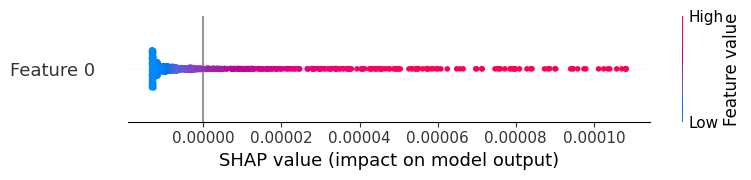

In [ ]:
import shap

# Criar o explicador SHAP para o modelo de ataque, com base nas previsões dos modelos sombra no conjunto de treinamento (xtr_att)
explainer = shap.Explainer(model_attack, xtr_att[:1000])

# Calcular os valores SHAP para as primeiras 1000 amostras do conjunto de teste (xts_att contém as previsões do modelo alvo)
shap_values = explainer(xtr_att[:1000])  # xts_att contém as previsões do modelo alvo

# Exibir um resumo das contribuições das características (as previsões dos modelos sombra)
shap.summary_plot(shap_values, xtr_att[:1000])




In [ ]:
# Visualizar as contribuições de uma amostra específica (primeira amostra, por exemplo)
shap.force_plot(shap_values[0])



In [ ]:
# Visualizar a relação entre uma característica específica e sua contribuição (dependence plot)
shap.dependence_plot(0, shap_values, xtr_att[:1000])

In [ ]:
importance = np.abs(shap_values.values).mean(axis=1)  # Média dos valores absolutos de SHAP para cada amostra

# Ordenar as amostras por sua importância
top_10_idx = np.argsort(importance)[-10:]  # Índices das 10 amostras mais importantes

# Visualizar as 10 amostras mais importantes
print("Top 10 amostras mais importantes para o treinamento do modelo de ataque:")
for idx in top_10_idx:
    print(f"Amostra {idx} com importância {importance[idx]}")

Top 10 amostras mais importantes para o treinamento do modelo de ataque:
Amostra 50 com importância 0.00010251939296723744
Amostra 387 com importância 0.00010359227657319448
Amostra 7 com importância 0.0001040691137313976
Amostra 304 com importância 0.00010585725307465932
Amostra 920 com importância 0.00010716855525971791
Amostra 216 com importância 0.00010818183422089955
Amostra 312 com importância 0.00010818183422089955
Amostra 574 com importância 0.00010818183422089955
Amostra 762 com importância 0.00010818183422089955
Amostra 931 com importância 0.00010818183422089955


## SHAP Rastreado

In [ ]:
import shap

# First create the structured test data with differences between models
def create_model_differences_dataset(test_set_df):
    # Pivot the predictions to get one column per model
    model_predictions = pd.pivot_table(
        test_set_df,
        values='prediction',
        index='sample_index',
        columns='model_name',
        aggfunc='first'
    ).reset_index()
    
    # Calculate differences between target and each shadow model
    difference_features = []
    feature_names = []
    
    # Get all shadow model names
    shadow_models = [col for col in model_predictions.columns if 'shadow' in col]
    
    for shadow in shadow_models:
        diff_col = f'diff_{shadow}_target'
        model_predictions[diff_col] = model_predictions[shadow] - model_predictions['target']
        difference_features.append(model_predictions[diff_col])
        feature_names.append(f'Difference ({shadow} - target)')
    
    # Stack differences into a numpy array
    X_diff = np.column_stack(difference_features)
    
    return X_diff, feature_names

# Create the difference features
X_diff, feature_names = create_model_differences_dataset(test_set_df)

# Create SHAP explainer with the difference features
explainer = shap.Explainer(model_attack, X_diff)

# Calculate SHAP values
shap_values = explainer(X_diff)

# Plot SHAP summary
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_diff, feature_names=feature_names)
plt.title("SHAP Values for Model Differences")

# Create detailed analysis of SHAP values
def analyze_shap_by_membership(shap_values, X_diff, test_set_df, feature_names):
    # Get unique sample indices
    sample_indices = test_set_df['sample_index'].unique()
    
    # Create DataFrame with SHAP values and metadata
    shap_df = pd.DataFrame(shap_values.values, columns=feature_names)
    shap_df['is_member'] = test_set_df['is_member']
    shap_df['true_label'] = test_set_df['true_label']
    
    print("\nSHAP Analysis by Membership Status:")
    print("\nAverage absolute SHAP values for members vs non-members:")
    member_shap = shap_df[shap_df['is_member'] == 0][feature_names].abs().mean()
    nonmember_shap = shap_df[shap_df['is_member'] == 1][feature_names].abs().mean()
    
    comparison_df = pd.DataFrame({
        'Member Impact': member_shap,
        'Non-member Impact': nonmember_shap
    })
    print(comparison_df)
    
    # Plot SHAP values separately for members and non-members
    plt.figure(figsize=(15, 6))
    
    plt.subplot(1, 2, 1)
    shap.summary_plot(
        shap_values[test_set_df['is_member'] == 0],
        X_diff[test_set_df['is_member'] == 0],
        feature_names=feature_names,
        title="SHAP Values for Members",
        show=False
    )
    
    plt.subplot(1, 2, 2)
    shap.summary_plot(
        shap_values[test_set_df['is_member'] == 1],
        X_diff[test_set_df['is_member'] == 1],
        feature_names=feature_names,
        title="SHAP Values for Non-members",
        show=False
    )
    
    plt.tight_layout()
    plt.show()

# Run the detailed SHAP analysis
analyze_shap_by_membership(shap_values, X_diff, test_set_df, feature_names)

# Save the SHAP analysis results
shap_results = {
    'shap_values': shap_values.values,
    'feature_names': feature_names,
    'X_diff': X_diff,
    'metadata': test_set_df
}
np.save(f'./shap_analysis_results_{data_size}.npy', shap_results)

## SHap Rastreado 2

In [28]:
# First, modify the attack model to accept the difference features
def create_attack_model_with_differences(num_shadow_models):
    """Creates attack model that accepts differences between models as features"""
    num_features = num_shadow_models  # number of differences (each shadow model vs target)
    
    model_attack = Sequential([
        # Input shape matches number of difference features
        Dense(5, input_shape=(num_features,), activation='sigmoid', name='hidden'),
        Dense(1, activation='sigmoid', name='output')
    ])
    
    opt = keras.optimizers.Adam(learning_rate=0.001, decay=1e-7)
    model_attack.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model_attack

# Create the difference features for training data
def create_difference_features(predictions_df, is_training=True):
    """Creates features based on differences between model predictions"""
    # Pivot the predictions to get one column per model
    model_predictions = pd.pivot_table(
        predictions_df,
        values='prediction',
        index='sample_index',
        columns='model_name',
        aggfunc='first'
    ).reset_index()
    
    # Calculate differences between target and each shadow model
    difference_features = []
    feature_names = []
    
    # Get all shadow model names
    shadow_models = [col for col in model_predictions.columns if 'shadow' in col]
    
    for shadow in shadow_models:
        diff_col = f'diff_{shadow}_target'
        model_predictions[diff_col] = model_predictions[shadow] - model_predictions['target']
        difference_features.append(model_predictions[diff_col])
        feature_names.append(f'Difference ({shadow} - target)')
    
    # Stack differences into a numpy array
    X_diff = np.column_stack(difference_features)
    
    return X_diff, feature_names

# Create training and test datasets with differences
X_train_diff, feature_names = create_difference_features(train_set_df, is_training=True)
X_test_diff, _ = create_difference_features(test_set_df, is_training=False)

# Create and train the modified attack model
num_shadow_models = 5  # adjust based on your ns value
model_attack = create_attack_model_with_differences(num_shadow_models)

# Train the model with the difference features
hist_attack = model_attack.fit(
    X_train_diff, ytr_att,
    batch_size=32,
    epochs=100,
    validation_data=(X_test_diff, yts_att_combined),
    shuffle=True,
    verbose=0
)

# Now create SHAP explainer with the difference features
explainer = shap.Explainer(model_attack, X_train_diff[:1000])  # Use subset for efficiency
shap_values = explainer(X_test_diff)

# Plot SHAP summary
plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_values, 
    X_test_diff,
    feature_names=feature_names,
    show=False
)
plt.title("SHAP Values for Model Differences")
plt.tight_layout()
plt.show()

# Create detailed analysis of SHAP values
def analyze_shap_by_membership(shap_values, X_diff, test_set_df, feature_names):
    """Analyzes SHAP values separately for members and non-members"""
    # Create DataFrame with SHAP values and metadata
    shap_df = pd.DataFrame(shap_values.values, columns=feature_names)
    shap_df['is_member'] = test_set_df['is_member']
    
    # Calculate average absolute SHAP values
    print("\nAverage absolute SHAP values:")
    print("\nFor members:")
    print(shap_df[shap_df['is_member'] == 0][feature_names].abs().mean())
    print("\nFor non-members:")
    print(shap_df[shap_df['is_member'] == 1][feature_names].abs().mean())
    
    # Create separate plots for members and non-members
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Members
    member_mask = test_set_df['is_member'] == 0
    shap.summary_plot(
        shap_values[member_mask],
        X_diff[member_mask],
        feature_names=feature_names,
        ax=ax1,
        show=False
    )
    ax1.set_title("SHAP Values for Members")
    
    # Non-members
    non_member_mask = test_set_df['is_member'] == 1
    shap.summary_plot(
        shap_values[non_member_mask],
        X_diff[non_member_mask],
        feature_names=feature_names,
        ax=ax2,
        show=False
    )
    ax2.set_title("SHAP Values for Non-members")
    
    plt.tight_layout()
    plt.show()

# Run the analysis
analyze_shap_by_membership(shap_values, X_test_diff, test_set_df, feature_names)

KeyError: 'target'

## Rastreando conjunto de treino

In [25]:
# First, create structured data for training set
train_set_data = []

# Track data for each shadow model
for i in np.arange(ns):
    model_shadow = load_model(f'UCI_Adult_shadow_{data_size}_{i}.h5')
    
    # Get predictions from shadow model on its train and test data
    shadow_tr_preds = model_shadow.predict(xtr_shadow)
    shadow_ts_preds = model_shadow.predict(xts_shadow)
    
    # Add training samples (members)
    for idx in range(len(shadow_tr_preds)):
        train_set_data.append({
            'prediction': float(shadow_tr_preds[idx]),
            'is_member': 0,  # member of training set
            'true_label': int(ytr_shadow[idx]),
            'model_name': f'shadow_{i}',
            'sample_index': idx,
            'data_split': 'train'
        })
    
    # Add test samples (non-members)
    for idx in range(len(shadow_ts_preds)):
        train_set_data.append({
            'prediction': float(shadow_ts_preds[idx]),
            'is_member': 1,  # non-member (test set)
            'true_label': int(yts_shadow[idx]),
            'model_name': f'shadow_{i}',
            'sample_index': idx,
            'data_split': 'test'
        })

# Convert to DataFrame
train_set_df = pd.DataFrame(train_set_data)



313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step


/tmp/ipykernel_83135/1336513710.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'prediction': float(shadow_tr_preds[idx]),
/tmp/ipykernel_83135/1336513710.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'prediction': float(shadow_ts_preds[idx]),


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 276us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step


In [26]:
train_set_df

,prediction,is_member,true_label,model_name,sample_index,data_split
0,0.504088,0,0,shadow_0,0,train
1,0.298486,0,1,shadow_0,1,train
2,0.827214,0,1,shadow_0,2,train
3,0.014987,0,0,shadow_0,3,train
4,0.526238,0,0,shadow_0,4,train
...,...,...,...,...,...,...
99995,0.010776,1,0,shadow_4,9995,test
99996,0.362464,1,1,shadow_4,9996,test
99997,0.710084,1,0,shadow_4,9997,test
99998,0.729532,1,1,shadow_4,9998,test


In [38]:
# Create the difference features for both training and test sets
def create_model_differences_dataset(df):
    """Creates features based on differences between model predictions"""
    # Pivot the predictions to get one column per model
    model_predictions = pd.pivot_table(
        df,
        values='prediction',
        index=['sample_index', 'data_split'],
        columns='model_name',
        aggfunc='first'
    ).reset_index()
    
    # Get reference shadow model (first one)
    reference_model = [col for col in model_predictions.columns if 'shadow_0' in col][0]
    
    # Calculate differences between shadow models
    difference_features = []
    feature_names = []
    
    # Get all shadow model names except the reference
    shadow_models = [col for col in model_predictions.columns 
                    if 'shadow' in col and col != reference_model]
    
    # Calculate differences between shadow models
    for shadow in shadow_models:
        diff_col = f'diff_{shadow}_{reference_model}'
        model_predictions[diff_col] = model_predictions[shadow] - model_predictions[reference_model]
        difference_features.append(model_predictions[diff_col])
        feature_names.append(f'Difference ({shadow} - {reference_model})')
    
    # Stack differences into a numpy array
    X_diff = np.column_stack(difference_features)
    
    return X_diff, feature_names

# Create difference features for training and test sets
X_train_diff, feature_names = create_model_differences_dataset(train_set_df)
X_test_diff, _ = create_model_differences_dataset(test_set_df)

# Create and train the modified attack model
num_differences = len(feature_names)  # number of difference features
model_attack = Sequential([
    Dense(5, input_shape=(num_differences,), activation='sigmoid', name='hidden'),
    Dense(1, activation='sigmoid', name='output')
])

opt = keras.optimizers.Adam(learning_rate=0.001, decay=1e-7)
model_attack.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

# Train the model with the difference features
hist_attack = model_attack.fit(
    X_train_diff, train_set_df['is_member'].values,
    batch_size=32,
    epochs=100,
    validation_data=(X_test_diff, test_set_df['is_member'].values),
    shuffle=True,
    verbose=0
)

# Create SHAP explainer with the difference features
explainer = shap.Explainer(model_attack, X_train_diff[:1000])
shap_values = explainer(X_test_diff)

# Plot SHAP summary
plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_values, 
    X_test_diff,
    feature_names=feature_names,
    show=False
)
plt.title("SHAP Values for Model Differences")
plt.tight_layout()
plt.show()

# Save the complete tracked datasets
tracking_data = {
    'train_set': train_set_df,
    'test_set': test_set_df,
    'X_train_diff': X_train_diff,
    'X_test_diff': X_test_diff,
    'feature_names': feature_names,
    'shap_values': shap_values.values
}
np.save(f'./mia_tracking_data_{data_size}.npy', tracking_data)

/media/emanuel/sdd_sata/projetos/projeto_mestrado_ofc/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/media/emanuel/sdd_sata/projetos/projeto_mestrado_ofc/.venv/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 20000
'y' sizes: 100000


In [33]:
train_set_df

,prediction,is_member,true_label,model_name,sample_index,data_split
0,0.504088,0,0,shadow_0,0,train
1,0.298486,0,1,shadow_0,1,train
2,0.827214,0,1,shadow_0,2,train
3,0.014987,0,0,shadow_0,3,train
4,0.526238,0,0,shadow_0,4,train
...,...,...,...,...,...,...
99995,0.010776,1,0,shadow_4,9995,test
99996,0.362464,1,1,shadow_4,9996,test
99997,0.710084,1,0,shadow_4,9997,test
99998,0.729532,1,1,shadow_4,9998,test


In [39]:
X_train_diff.shape

(20000, 4)

In [40]:
# Print shapes to debug
print("Shape of xtr_att:", xtr_att.shape)
print("Shape of ytr_att:", ytr_att.shape)

# First, create structured data for training set with correct shapes
train_set_data = []

# Track data for each shadow model
for i in np.arange(ns):
    start_idx = i * 2 * data_size
    end_idx = (i + 1) * 2 * data_size
    
    # Get the predictions and labels for this shadow model
    model_preds = xtr_att[start_idx:end_idx]
    model_labels = ytr_att[start_idx:end_idx]
    true_labels = xtr_att_truelabels[start_idx:end_idx]
    
    # First half is training data (members)
    for idx in range(data_size):
        train_set_data.append({
            'prediction': float(model_preds[idx]),
            'is_member': float(model_labels[idx]),
            'true_label': int(true_labels[idx]),
            'model_name': f'shadow_{i}',
            'sample_index': idx,
            'data_split': 'train'
        })
    
    # Second half is test data (non-members)
    for idx in range(data_size):
        train_set_data.append({
            'prediction': float(model_preds[data_size + idx]),
            'is_member': float(model_labels[data_size + idx]),
            'true_label': int(true_labels[data_size + idx]),
            'model_name': f'shadow_{i}',
            'sample_index': idx,
            'data_split': 'test'
        })

# Convert to DataFrame
train_set_df = pd.DataFrame(train_set_data)

print("Number of samples in train_set_df:", len(train_set_df))

# Create the difference features for both training and test sets
def create_model_differences_dataset(df):
    """Creates features based on differences between model predictions"""
    # Pivot the predictions to get one column per model
    model_predictions = pd.pivot_table(
        df,
        values='prediction',
        index=['sample_index', 'data_split'],
        columns='model_name',
        aggfunc='first'
    ).reset_index()
    
    # Get reference shadow model (first one)
    reference_model = [col for col in model_predictions.columns if 'shadow_0' in col][0]
    
    # Calculate differences between shadow models
    difference_features = []
    feature_names = []
    
    # Get all shadow model names except the reference
    shadow_models = [col for col in model_predictions.columns 
                    if 'shadow' in col and col != reference_model]
    
    # Calculate differences between shadow models
    for shadow in shadow_models:
        diff_col = f'diff_{shadow}_{reference_model}'
        model_predictions[diff_col] = model_predictions[shadow] - model_predictions[reference_model]
        difference_features.append(model_predictions[diff_col])
        feature_names.append(f'Difference ({shadow} - {reference_model})')
    
    # Stack differences into a numpy array
    X_diff = np.column_stack(difference_features)
    
    return X_diff, feature_names, model_predictions

# Create difference features for training and test sets
X_train_diff, feature_names, train_predictions = create_model_differences_dataset(train_set_df)
X_test_diff, _, test_predictions = create_model_differences_dataset(test_set_df)

print("Shape of X_train_diff:", X_train_diff.shape)
print("Shape of training labels:", train_set_df['is_member'].values.shape)
print("Shape of X_test_diff:", X_test_diff.shape)
print("Shape of test labels:", test_set_df['is_member'].values.shape)

# Create and train the modified attack model
num_differences = len(feature_names)  # number of difference features
model_attack = Sequential([
    Dense(5, input_shape=(num_differences,), activation='sigmoid', name='hidden'),
    Dense(1, activation='sigmoid', name='output')
])

opt = keras.optimizers.Adam(learning_rate=0.001, decay=1e-7)
model_attack.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

# Train the model with the difference features
hist_attack = model_attack.fit(
    X_train_diff, train_set_df['is_member'].values,
    batch_size=32,
    epochs=100,
    validation_data=(X_test_diff, test_set_df['is_member'].values),
    shuffle=True,
    verbose=1
)

Shape of xtr_att: (100000, 1)
Shape of ytr_att: (100000, 1)


/tmp/ipykernel_83135/3721421044.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'prediction': float(model_preds[idx]),
/tmp/ipykernel_83135/3721421044.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'is_member': float(model_labels[idx]),
/tmp/ipykernel_83135/3721421044.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'prediction': float(model_preds[data_size + idx]),
/tmp/ipykernel_83135/3721421044.py:33: DeprecationWarning: Conversion of an array wit

Number of samples in train_set_df: 100000
Shape of X_train_diff: (20000, 4)
Shape of training labels: (100000,)
Shape of X_test_diff: (20000, 4)
Shape of test labels: (30000,)


/media/emanuel/sdd_sata/projetos/projeto_mestrado_ofc/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/media/emanuel/sdd_sata/projetos/projeto_mestrado_ofc/.venv/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 20000
'y' sizes: 100000


In [ ]:
Shape of xtr_att: (100000, 1)
Shape of ytr_att: (100000, 1)
Number of samples in train_set_df: 100000
Shape of X_train_diff: (20000, 4)
Shape of training labels: (100000,)
Shape of X_test_diff: (20000, 4)
Shape of test labels: (30000,)